# Tâche 3 - Classification automatique de descriptions d'incidents

Cette tâche vise à classifier de courts textes décrivant des incidents qui se sont produits sur des chantiers de construction. Pour chaque incident, on retrouve une étiquette de 1 à 4. Ces étiquettes sont inconnues et vous devrez tenter de les identifier à la section 3 de ce *notebook*. 

Les objectifs de cette tâche sont: 
- de se familiariser avec la classification de texte
- d'apprendre à utiliser les fonctions de base de scikit-learn
- de comprendre comment représenter un texte sous la forme d'un sac de mots (*bag of words*)
- de faire l'évaluation d'un modèle de classification avec un corpus de test
- de tenter d'interpréter les résultats d'un modèle à l'aide des poids d'attributs. 

Pour la première partie, vous devez construire une fonction (*train_and_test_classifier*) qui entraîne un modèle (les options étant la régression logistique et le naïf bayésien) et en faire l'évaluation sur des données d'entraînement et des données de test. Deux fichiers de textes sont disponibles pour mener votre expérimentation (voir Section 1). 

Pour la deuxième partie, vous devez tentez de déterminer à quoi correspond chacune des classes d’incident. Faites une analyse des poids des modèles pour proposer des étiquettes pour chacune des classes. Vous pouvez vous inspirer des *notebooks* disponibles sur le site du cours. Expliquez clairement comment vous êtes arrivé à vos conclusions. L’important ici est de dégager le thème principal à partir de vos observations et non pas de trouver la formulation exacte des étiquettes. 

Merci de respecter les signatures des fonctions *train_and_test_classifier* et *load_incident_dataset*.

Note sur la lemmatisation: Cette normalisation de texte nécessite l'utilisation d'un modèle qui repose sur l'apprentissage automatique. En conséquence, son temps d'exécution est plus long que le stemming. Si jamais cela ralentit trop vos expérimentations, il est possible de ne faire le traitement qu'une seule fois en sauvegardant les résultats après la première lemmatisation d'un fichier. Cela n'est toutefois pas exigé pour la remise de votre travail et ne sera pas évalué. 

## Section 1 - Lecture des fichiers de données

Voici les fichiers mis à votre disposition pour mener vos expérimentations. La fonction *load_incident_data* peut être utilisée pour lire les 2 fichiers (train et test). Rien à modifier dans cette section. 

In [44]:
import json

train_json_fn = "./data/t3_train.json"
test_json_fn = "./data/t3_test.json"


def load_incident_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
    return incident_list

In [45]:
train_list = load_incident_dataset(train_json_fn)
print("Nombre d'incidents:", len(train_list))
print("\nUn exemple:\n", train_list[10])

Nombre d'incidents: 2097

Un exemple:
 {'text': ' On February 7  2012 an employee was carrying a 24 inch metal pump jack  scaffolding support that came in contact or near contact with a high voltage  wire. The employee was electrocuted and died.                                   ', 'label': 1}


In [46]:
test_list = load_incident_dataset(test_json_fn)
print("Nombre d'incidents", len(test_list))
incident = test_list[10]
print("\nUne description d'incident:", incident["text"])
print("\nSon étiquette:", incident["label"])

Nombre d'incidents 878

Une description d'incident:  On January 25  2012  Employee#1 and Employee #2 were on the first level of the  one story wooden structure when it collapsed. Employee #1 was able to crawl  out from underneath the fallen structure and received out-patient medical care  for minor injuries. Employee # 2 died at the scene.                             

Son étiquette: 1


## Section 2 - Entraînement et évaluation des modèles  

Vous pouvez ajouter tout le code dont vous avez besoin pour l'entraînement. Merci de ne pas modifier la signature de la fonction d'entraînement et de bien expliquer votre démarche et vos résultats. N'oubliez pas de faire une recommandation de modèle. Vous pouvez ajouter des cellules au *notebook* si nécessaire. 

In [48]:
# Importer ici les librairies dont vous avez besoin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import pandas as pd
import time


def train_and_test_classifier(train_fn, test_fn, model='NB'):
    """
    :param train_fn et test_fn: les 2 fichiers utilisées pour entraîner et tester les classificateurs.
    :param model: le type de classificateur. NB = Naive Bayes, LR = Régression logistique.
    :return: un dictionnaire contenant 6 valeurs:
                 - 'model_trained' = Le modéle entrainé
                 - 'accuracy_train' = l'accuracy à l'entraînement (validation croisée)
                 - 'accuracy_test' = l'accuracy sur le jeu de test
                 - 'confusion_matrix' = la matrice de confusion calculée par scikit-learn sur les données de test
                 - 'time_spent' = Le temps de traitement 
                 - 'vectorizer' = le vecteur de mots sur les données d'entrainement.
                 - 'classification_report' = les métriques calculés par sklearn.metrics.classification_report
                 
    """
    
    # Votre code...
    results = dict()
    
    def startTime():
        return time.time()

    def endTime(start_time):
        end_time = time.time()
        #print(f"{info} - Durée de l'opération : {elapsed_time:.2f} s")
        return (end_time - start_time)
        
    
    def data_preprocess (my_data):
        """
        Transforme les données lues depuis un fichier de type Json en une liste de dictionnaire 
        :param my_data: le nom du fichier de type Json
        :return: une liste de dictionnaire :
            - my_X : le contenu des documents
            - my_y : la liste des classes de chaque document
        """
        #initialisation des variables:
        my_X=[]
        my_y=[]
        
        for i in range (len(my_data)):
            my_X.append(my_data[i]['text'])
            my_y.append(my_data[i]['label'])
        return my_X, my_y
        
    def cross_validation(classifier, X, y):
        """
        Fait la vaildation croisée Kfold en découpant les données d'entraienement en 5 partitions.
        :param classifier: le modéle
        :X : les attributs du modèle
        :y : les etiquettes à prédire
        """
        scores = cross_val_score(classifier, X, y, cv=5)
        return scores
    #Début du chronométrage:
    my_start_time = startTime()
    
    #Étape 1 : Trasnformation des données du corpus de document et de la classe définie pour chaque document
    X_train, y_train = data_preprocess(train_fn)
    X_test, y_test = data_preprocess(test_fn)

    #Étape 2 : prétraitement des données en sac de mot avec la classe  CountVectorizer
    ## On fait le choix de ne pas garder tout ce qui est numérique : token_pattern="[^\W\d_]+"
    vectorizer = CountVectorizer(lowercase=True,token_pattern="[^\W\d_]+")
    vectorizer.fit(X_train)
    results['vectorizer']=vectorizer.fit(X_train)
    X_train_vectorized = vectorizer.transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    #Étape 3 : Création du nodéle soit en NaiveBayes soit en Regression Logistisque.
    if model=='NB':
        my_classifier = MultinomialNB()
       
    if model=='LR':
        my_classifier = LogisticRegression(multi_class='multinomial',max_iter=200)
        
       
    #entraienement du modèle:
    my_classifier.fit(X_train_vectorized, y_train)
            
    # Calcul de prédictions de la classe avec les données de tests:
    y_pred_class = my_classifier.predict(X_test_vectorized)
    results['accuracy_test'] = metrics.accuracy_score(y_test, y_pred_class)
    results['classification_report'] = classification_report(y_test, y_pred_class)

    # calcul de l'accuracy en k-fold avec les données d'entrainement:
    results['accuracy_train']= cross_validation(my_classifier, X_train_vectorized, y_train).mean()
            
    ## Calcul de la matrice de confusion avec les données de test
    results['confusion_matrix'] = metrics.confusion_matrix(y_test, y_pred_class)

    # retourne le modéle au complet
    results['model_trained'] = my_classifier

    #fin du chonométrage
    my_time_spent = endTime(my_start_time)
    results['time_spent'] = my_time_spent
    
    return results

In [49]:
#Génération d'un modèle LR (my_model_logreg) et d'un modèle NB (my_model_nb) pour démonstration et validation 
my_model_nb = train_and_test_classifier(train_list, test_list)
my_model_logreg = train_and_test_classifier(train_list, test_list,'LR')

### Évaluation des modéles

L'évaluation des modéles est faite à partir des résultats obtenu par la fonction train_and_test_classifier.
Les résultats retounés sont la matrice de confusion, l'accuracy et le temps de traitement.
Afin de mieux visualiser les résultats, une version graphique des résultats est présentée.

1. Naive Bayes

Accuracy du modèle :  0.7289293849658315
Métrique de chaque classe du modéle :  
               precision    recall  f1-score   support

           1       0.80      0.56      0.66       163
           2       0.79      0.61      0.69       207
           3       0.69      0.86      0.76       275
           4       0.72      0.80      0.75       233

    accuracy                           0.73       878
   macro avg       0.75      0.71      0.72       878
weighted avg       0.74      0.73      0.72       878

Temps de traitement du modèle :  0.6850669384002686


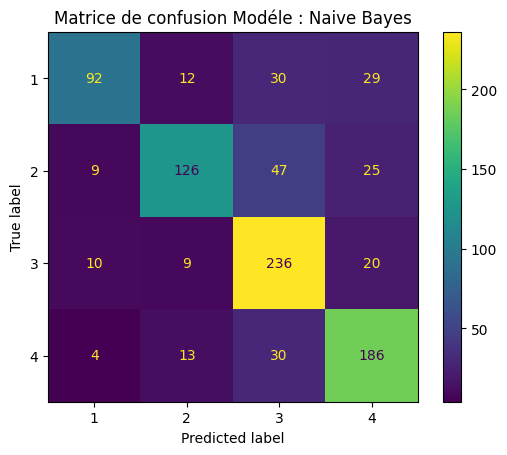

In [52]:
disp_cm_nb = ConfusionMatrixDisplay(confusion_matrix=my_model_nb['confusion_matrix'], display_labels = [1, 2, 3, 4])
disp_cm_nb.plot()
disp_cm_nb.ax_.set_title("Matrice de confusion Modéle : Naive Bayes")
print ("Accuracy du modèle : ",my_model_nb['accuracy_test'])
print("Métrique de chaque classe du modéle : " ,"\n", my_model_nb['classification_report'])
print ("Temps de traitement du modèle : ",my_model_nb['time_spent'])

Le modéle Naive Bayes obtient un score honorable de 72.8% pour la métrique Accuracy. Presque 73% des exemples contenu dans le jeu de tests ont été correctement classifiés. La précision de la classe 3 (0.69) est inférieure aux 3 autres classes (classe 1 =  0.80; classe 2 = 0.79; classe 4 = 0.72)
Le nombre de bonnnes prédictions est 236, mais on contate que c'est dans cette classe également qu'il y a le plus de mauvaises prédictions 113 (30+47+30=113)


2. Régression Logistique


Accuracy du modèle :  0.9908883826879271
Métrique de chaque classe du modéle :  
               precision    recall  f1-score   support

           1       0.99      0.98      0.98       163
           2       0.99      1.00      0.99       207
           3       1.00      0.99      0.99       275
           4       0.98      1.00      0.99       233

    accuracy                           0.99       878
   macro avg       0.99      0.99      0.99       878
weighted avg       0.99      0.99      0.99       878

Temps de traitement du modèle :  5.812518835067749


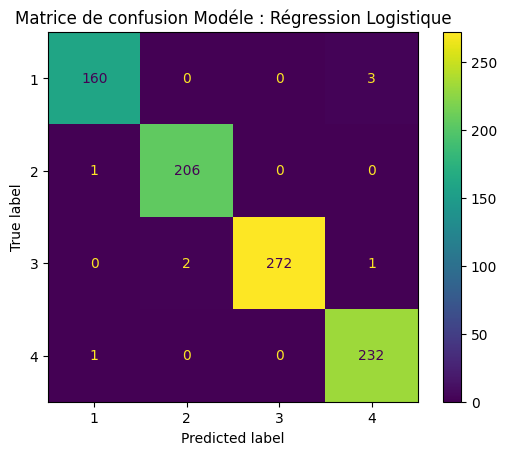

In [55]:
disp_cm_logreg = ConfusionMatrixDisplay(confusion_matrix=my_model_logreg['confusion_matrix'], display_labels = [1, 2, 3, 4])
disp_cm_logreg.plot()
disp_cm_logreg.ax_.set_title("Matrice de confusion Modéle : Régression Logistique")
print ("Accuracy du modèle : ",my_model_logreg['accuracy_test'])
print("Métrique de chaque classe du modéle : " ,"\n", my_model_logreg['classification_report'])
print ("Temps de traitement du modèle : ",my_model_logreg['time_spent'])

Le modéle utilsant la régession logisitique a un temps d'exécution relatif trés supérieur à celui du modéle Naives Bayes (5.66 mms comparativement à 0.6 mms). 
Par contre la qualité des prédictions est largement supérieure à . On attient un taux de réussite de 0.99 en moyenne sur les classes. Avec un sans faute pour la classe 3 comparativevent à un nombre d'erreur supérieur à 100 (30+47+30=107) dans le modéle Naive Bayes.
Malgré un temps de traitement supérieur, le modéle par Régression Logistique est préférable au vu de la trés bonne prédiction obtenue sur les données de test

## Section 3 - À quoi correspondent les classes? Explicabilité du modèle

En utilisant les poids des modèles, tentez d'attribuer une signification aux différentes classes. Il devrait être possible de faire une analyse de définir précisément la nature et la composition des classes. Toutefois, l'important est d'utiliser ce qu'on observe dans les modèles pour fournir une explication plausible.

Vous pouvez ajouter tout le code et toutes les cellules dont vous avez besoin.

In [58]:
# Création d'un Dataframe comportant les coefficients de chaque attribut du modéle de chaque classe
df = pd.DataFrame(my_model_logreg['vectorizer'].get_feature_names_out(), columns =['Mots']) 
for i in range(len(my_model_logreg['model_trained'].classes_)):
    df[my_model_logreg['model_trained'].classes_[i]] = list(my_model_logreg['model_trained'].coef_[i])

In [59]:
# affiche les 4 mots ayant le plus grand poids pour chaque classe
for i in (my_model_logreg['model_trained'].classes_):
    print(pd.DataFrame(df.nlargest(4,i),columns=['Mots',i]))
    

          Mots         1
3999   january  2.966517
2791  february  2.928420
4556     march  2.858072
3043      four  0.236947
       Mots         2
4072   june  3.322339
346   april  2.929310
4602    may  2.910190
3255  grade  0.245248
           Mots         3
6708  september  3.260219
481      august  3.214501
4065       july  3.140378
8045      truss  0.188396
          Mots         4
5042  november  3.369844
5103   october  3.287184
1926  december  2.821503
5509      pile  0.216771


On constate que pour chaque classe, les mots les plus discriminant sont 3 mois successifs de l'année. Par conséquent, nous pouvons en déduire que les classes 1, 2, 3 et 4 représentent chacune un trimestre.

Lors des premières itérations de conception du modèle, nous avons fait varier le contenu du sac de mot (Word of bag) de base. Nous avions au départ enlever les "Stop Word" de la langue anglaise du modèle dans le but que notre modèle ne soit pas bruité par la fréquence élevée de ces mots.
Ceci a eu pour effet de retirer le mot « may » du vocabulaire du modèle. Car ce dernier a deux sens : le mois de l'année ou un auxiliaire modal et fait partie des "stop words". Ainsi la classe 2 était discriminée par une valeur numérique en troisième rang de coefficient.

Par conséquent, nous avons pris la décision de retirer du sac de mot de départ toutes les valeurs numériques et de conserver tous les autres mots vus dans les documents d'entrainement, faisant ainsi apparaitre le mot "may" comme troisième mot le plus discriminant pour la classe 2. Ce qui est cohérent avec les résultats des autres classes.

Par contre, la conservation de tous les mots vus dans le jeu de données d'entrainement a eu pour conséquence d'obtenir un message d'avertissement lors de la phase d'entrainement du modèle de type régression logistique :

**ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.**

Par défaut, la valeur maximale du nombre d'itération, dans la construction du modèle de régression logistique, est de 100 :
Information provenant de la documentation de scikit-learn :

**max_iterint, default=100 Maximum number of iterations taken for the solvers to converge.**

Ce qui signifie dans notre cas, que le modèle n'avait probablement pas atteint le minimum de la fonction de perte en 100 itérations. Nous avons augmenté ce nombre à 200. D'où le paramétrage suivant dans notre code :

**my_classifier = LogisticRegression(multi_class='multinomial',max_iter=200)**


## Section 4 - Section réservée pour nos tests